In [1]:
import os
os.chdir('ml-fastvit')

In [18]:
import timm
import torch
import torchvision.transforms as T
import torch.nn as nn
import models
import matplotlib.pyplot as plt
import numpy as np

from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen


In [64]:
class FastViTDecoder(nn.Module):
    def __init__(self, num_channels=[384, 192, 96, 48], output_channels=3):
        super().__init__()
        # Define Upsample layers
        self.upconv1 = nn.ConvTranspose2d(num_channels[0], num_channels[1], kernel_size=2, stride=2)
        self.act1 = nn.GELU()
        
        self.upconv2 = nn.ConvTranspose2d(num_channels[1], num_channels[2], kernel_size=2, stride=2)
        self.act2 = nn.GELU()

        self.upconv3 = nn.ConvTranspose2d(num_channels[2], num_channels[3], kernel_size=2, stride=2)
        self.act3 = nn.GELU()

        # Final layer to get back to original image size and channel count
        self.final_conv = nn.ConvTranspose2d(num_channels[3], output_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Start from the smallest feature map
        x = self.act1(self.upconv1(x[-1]))  # Upsample 384 to 192
        x = self.act2(self.upconv2(x))      # Upsample 192 to 96
        x = self.act3(self.upconv3(x))      # Upsample 96 to 48

        # Upsample to original image size
        x = self.final_conv(x)
        return x

# Initialize the decoder with the specified channel sizes
decoder = FastViTDecoder()

In [3]:
# To Train from scratch/fine-tuning
model = create_model("fastvit_t8", fork_feat=True)

In [4]:
checkpoint = torch.load('../pretrained/fastvit_t8.pth.tar')
model.load_state_dict(checkpoint['state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['norm0.weight', 'norm0.bias', 'norm0.running_mean', 'norm0.running_var', 'norm2.weight', 'norm2.bias', 'norm2.running_mean', 'norm2.running_var', 'norm4.weight', 'norm4.bias', 'norm4.running_mean', 'norm4.running_var', 'norm6.weight', 'norm6.bias', 'norm6.running_mean', 'norm6.running_var'], unexpected_keys=['conv_exp.se.reduce.weight', 'conv_exp.se.reduce.bias', 'conv_exp.se.expand.weight', 'conv_exp.se.expand.bias', 'conv_exp.rbr_conv.0.conv.weight', 'conv_exp.rbr_conv.0.bn.weight', 'conv_exp.rbr_conv.0.bn.bias', 'conv_exp.rbr_conv.0.bn.running_mean', 'conv_exp.rbr_conv.0.bn.running_var', 'conv_exp.rbr_conv.0.bn.num_batches_tracked', 'conv_exp.rbr_scale.conv.weight', 'conv_exp.rbr_scale.bn.weight', 'conv_exp.rbr_scale.bn.bias', 'conv_exp.rbr_scale.bn.running_mean', 'conv_exp.rbr_scale.bn.running_var', 'conv_exp.rbr_scale.bn.num_batches_tracked', 'head.weight', 'head.bias'])

In [41]:
# For inference
model.eval()      
model_inf = reparameterize_model(model)

In [59]:
# image = Image.open(urlopen(
#     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
# ))
# # OR
image = Image.open("../assets/demo2.jpg")
transform = T.Compose([
        T.Resize(400),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = transform(image).unsqueeze(0)

In [61]:
for o in output:
    print(o.shape)

torch.Size([1, 48, 100, 150])
torch.Size([1, 96, 50, 75])
torch.Size([1, 192, 25, 38])
torch.Size([1, 384, 13, 19])


In [66]:
%%timeit

output = model_inf(image)  # unsqueeze single image into batch of 1
# Example usage
# Assuming `output` is the list of feature maps from the encoder
reconstructed_img = decoder(output)
# print(reconstructed_img.shape)

32.6 ms ± 525 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


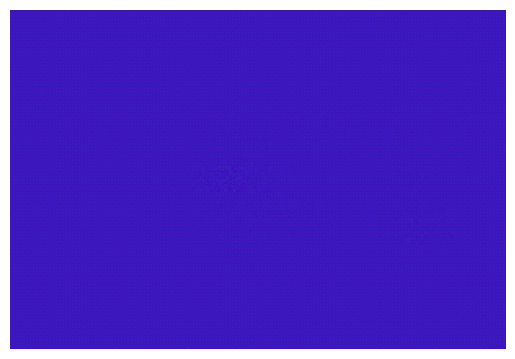

In [63]:
# Check if the batch dimension is present and has size 1
if reconstructed_img.ndim == 4 and reconstructed_img.shape[0] == 1:
    reconstructed_img = reconstructed_img.squeeze(0)  # Remove batch dimension, [C, H, W]

# Permute the dimensions from [C, H, W] to [H, W, C] for image display
reconstructed_img = reconstructed_img.permute(1, 2, 0)  # [H, W, C]

# Convert to numpy array
reconstructed_img = reconstructed_img.cpu().detach().numpy()

# Scale the pixel values if necessary
reconstructed_img = (reconstructed_img * 255).astype(np.uint8)

# Display the image
plt.imshow(reconstructed_img)
plt.axis('off')
plt.show()
